In [11]:
%load_ext iminizinc

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import IPython
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from datetime import datetime
# import talib
import pandas_ta as ta
# from talib.abstract import *
from math import *
from collections import OrderedDict
# import vectorbt as vbt    
import json
from decimal import *
getcontext().prec = 6
# import seaborn as sns

import mplfinance as mpf

matplotlib.rcParams.update({'font.size': 5, 'lines.linewidth': 0.5, 'figure.dpi': 300})
plt.rcParams['lines.linewidth'] = 0.5 


The iminizinc extension is already loaded. To reload it, use:
  %reload_ext iminizinc


In [4]:
odf = pd.read_json(r'../freq-user-data/data/binance/BTC_USDT-1d.json').dropna()
odf.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']

odf['date'] = pd.to_datetime(odf['timestamp'], unit='ms', utc=False)
# df.index = df['time']
# df.set_index('time', drop=True, inplace=True)
odf['idate'] = odf.date.dt.strftime('%Y%m%d')
odf.set_index(pd.DatetimeIndex(odf["date"]), inplace=True, drop=True)
# df = df[['time', 'symbol', 'source', 'resolution', 'open', 'high', 'low', 'close', 'volume']]
# df.to_csv (r'./data/binance/BTC_USDT-5m.csv', index = None)
# df.set_index('time')
odf = odf.sort_index()
odf

,timestamp,open,high,low,close,volume,date,idate
date,,,,,,,,
2021-01-01,1609459200000,28923.63,29600.00,28624.57,29331.69,54182.925011,2021-01-01,20210101
2021-01-02,1609545600000,29331.70,33300.00,28946.53,32178.33,129993.873362,2021-01-02,20210102
2021-01-03,1609632000000,32176.45,34778.11,31962.99,33000.05,120957.566750,2021-01-03,20210103
2021-01-04,1609718400000,33000.05,33600.00,28130.00,31988.71,140899.885690,2021-01-04,20210104
2021-01-05,1609804800000,31989.75,34360.00,29900.00,33949.53,116049.997038,2021-01-05,20210105
...,...,...,...,...,...,...,...,...
2023-05-07,1683417600000,28848.19,29138.29,28395.23,28430.10,30003.410280,2023-05-07,20230507
2023-05-08,1683504000000,28430.09,28631.01,27262.00,27668.79,68244.361790,2023-05-08,20230508
2023-05-09,1683590400000,27668.80,27818.00,27353.00,27628.27,40113.310690,2023-05-09,20230509


In [5]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [6]:
def PT(Q):
    d = None
    P, T, S, a, b, i, d = set(), set(), set(), 0, 0, 0, None
    for i in range(len(Q)):
        if d is None:
            if Q[a] >= Q[i]:
                d = 1 
            elif Q[i] >= Q[b]:
                d = -1
            if Q[a] < Q[i]:
                a = i
            elif Q[i] > Q[b]:
                b = i
            S = {i}
            
        elif d == 1:
            if Q[a] < Q[i]:
                S,a = {i},i
            elif Q[a] == Q[i]:
                S.add(i)
            elif Q[a] > Q[i]:
                P = P | S
                S,b,d = {i}, i, -1
        
        elif d == -1:
            if Q[i] < Q[b]:
                S,b = {i}, i
            elif Q[i] == Q[b]:
                S.add(i)
            elif Q[i] >= Q[b]:
                T = T | S
                S,a,d = {i}, i, 1
                  
    return sorted(P),sorted(T)

# PT(df.close)

peaks, troughs = PT(df.close)
# (list(peaks)).sort()
df.index[peaks]
# ax1.scatter(df.index[[peaks]], df.close[[peaks]])

NameError: name 'df' is not defined

### Find all the peaks and troughs

In [7]:

df = odf['2023-01-01':]
kl_n = len(df)
pktr_n = floor(len(df) / 7)
kl_close = df.close.astype(int).tolist()
pktr_n

18

In [8]:
%%minizinc -m bind

array[int] of int: kl_close;

int: kl_n;
set of int: KLN = 1..kl_n;
set of int: KLN0 = 0..kl_n;
int: pktr_n;
set of int: PKTR = 1..pktr_n;

array[PKTR] of var KLN0: apktr;

var PKTR: npktr;

constraint apktr[npktr] = 1;
constraint apktr[pktr_n] = kl_n;
constraint forall(j in 1..npktr-1)(apktr[j] = 0);

include "increasing.mzn";
constraint increasing(apktr);

constraint forall(i in npktr..pktr_n-1)(
    let { var KLN: idn = if kl_close[apktr[i]]>kl_close[apktr[i+1]] then i+1 else i endif, 
          var KLN: iup = if idn = i then i+1 else i endif} in
          forall(j in apktr[i]+1..apktr[i+1]-1)(kl_close[j] >= kl_close[apktr[idn]] /\ kl_close[j] <= kl_close[apktr[iup]] )
);

constraint forall(i in npktr..pktr_n-2)(
    kl_close[apktr[i]] >= kl_close[apktr[i+1]] /\ kl_close[apktr[i+1]] <= kl_close[apktr[i+2]]
    \/ kl_close[apktr[i]] <= kl_close[apktr[i+1]] /\ kl_close[apktr[i+1]] >= kl_close[apktr[i+2]]
    );

include "alldifferent.mzn";
constraint all_different_except_0(apktr);

solve maximize npktr;

In [9]:
apktrs = list(filter(lambda x: x > 0, apktr))
# apktrs = [160, 382, 422, 428]
apktrs = np.array(apktrs) -1 
apktrs

array([  0, 103, 130])

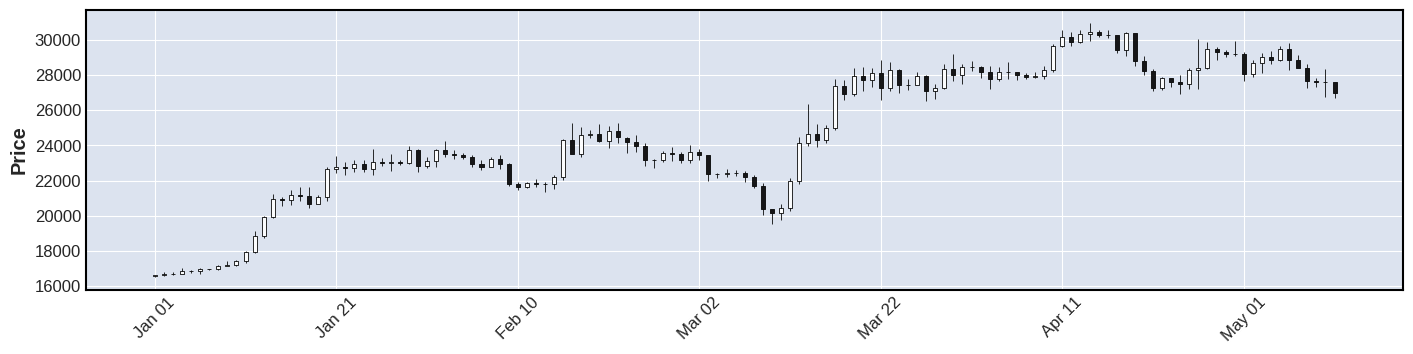

In [20]:
fig = mpf.figure(figsize=(17,8))
ax1 = fig.add_subplot(2,1,1)

mpf.plot(df, ax=ax1, type='candle')
# ax1.scatter(df.index[apktrs], df.close[apktrs])


### Find last n peaks

In [12]:
df = odf['2021-06-02':'2022-08-03']
kl_n = len(df)
pktr_n = 4 # Last 3 peaks inc last 
kl_close = df.close.astype(int).tolist()

In [13]:
%%minizinc -m bind

array[int] of int: kl_close;

int: kl_n;
set of int: KLN = 1..kl_n;
set of int: KLN0 = 0..kl_n;
int: pktr_n;
set of int: PKTR = 1..pktr_n;

array[PKTR] of var KLN0: apktr;

var PKTR: npktr;

constraint apktr[npktr] >= 1;
constraint apktr[pktr_n] = kl_n;
constraint forall(j in 1..npktr-1)(apktr[j] = 0);

include "increasing.mzn";
constraint increasing(apktr);

constraint forall(i in npktr..pktr_n-1)(
    let { var KLN: idn = if kl_close[apktr[i]]>kl_close[apktr[i+1]] then i+1 else i endif, 
          var KLN: iup = if idn = i then i+1 else i endif} in
          forall(j in apktr[i]+1..apktr[i+1]-1)(kl_close[j] >= kl_close[apktr[idn]] /\ kl_close[j] <= kl_close[apktr[iup]] )
);

constraint forall(i in npktr..pktr_n-2)(
    kl_close[apktr[i]] >= kl_close[apktr[i+1]] /\ kl_close[apktr[i+1]] <= kl_close[apktr[i+2]]
    \/ kl_close[apktr[i]] <= kl_close[apktr[i+1]] /\ kl_close[apktr[i+1]] >= kl_close[apktr[i+2]]
    );

include "alldifferent.mzn";
constraint all_different_except_0(apktr);

solve minimize npktr;


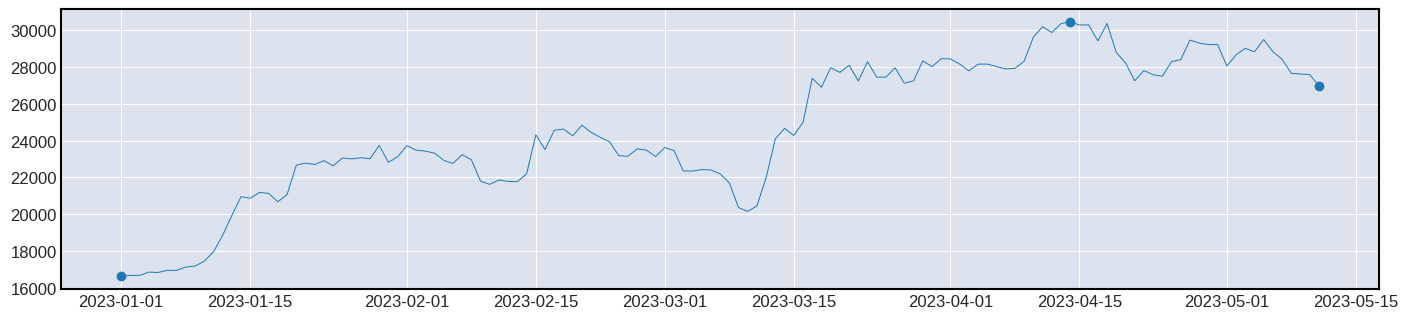

In [13]:
fig = mpf.figure(figsize=(17,8))
ax1 = fig.add_subplot(2,1,1)

ax1.plot(df.close, lw=0.7)
ax1.scatter(df.index[apktrs], df.close[apktrs])

### Find peaks only

In [15]:
df = odf['2021-01-01':]
kl_n = len(df)
# pktr_n = 4 # Last 3 peaks inc last 
kl_signal = df.close.astype(int).tolist()
with open('klines.dzn', 'w+') as f:
    f.write(f'kl_n = {len(df)};\n')
    f.write(f'kl_signal = [' + ', '.join(df.close.astype(int).astype(str)) + '];\n')

In [16]:
%%mzn_model going_up 

array[int] of int: kl_signal;

int: kl_n;
set of int: KLN = 1..kl_n;
set of int: KLN0 = 0..kl_n;
int: pktr_n = 4;
set of int: PKTR = 1..pktr_n;

array[PKTR] of var KLN: apktr;

predicate sig_increasing(array[KLN] of int: klsig, array[PKTR] of var KLN: apktr, int:start, int: end) =
    forall(i in apktr[start]+1..apktr[end]-1)(klsig[i] >= klsig[apktr[start]] /\ klsig[i] <= klsig[apktr[end]]);

predicate sig_decreasing(array[KLN] of int: klsig, array[PKTR] of var KLN: apktr, int:start, int: end) =
    forall(i in apktr[start]+1..apktr[end]-1)(klsig[i] <= klsig[apktr[start]] /\ klsig[i] >= klsig[apktr[end]]);

include "increasing.mzn";
constraint increasing(apktr);

constraint forall(i in 1..pktr_n div 2 )(
        sig_decreasing(kl_signal, apktr, i*2 - 1, i*2)
    );

constraint forall(i in 1..pktr_n div 2 -1 )(
        sig_increasing(kl_signal, apktr, i*2 , i*2 + 1)
    );

constraint forall(i in 1..pktr_n-1)(apktr[i+1]-apktr[i] > 1);

include "alldifferent.mzn";
constraint all_different_except_0(apktr);

%constraint exists
constraint kl_signal[apktr[2]] < kl_signal[apktr[4]];
constraint kl_signal[apktr[3]] > kl_signal[apktr[5]];

%solve minimize apktr[pktr_n-1] - apktr[1+1];
solve satisfy;

In [17]:
apktrs = %minizinc going_up -a
apktrs

  (array access out of bounds, array has index set 1..4, but given index is 5)
/tmp/tmpn3q3xry7/model.mzn:36.12-52
  in binary '>' operator expression
  in array access
  in array access

/tmp/tmpn3q3xry7/model.mzn:36.12-52
  in binary '>' operator expression
  in array access
  in array access
Solver output:
The problem is infeasible


[]

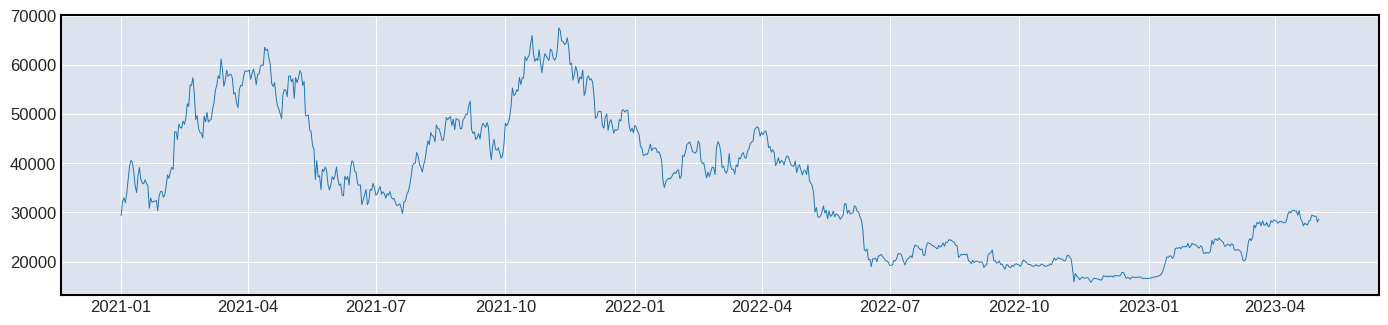

In [18]:

fig = mpf.figure(figsize=(17,8))
ax1 = fig.add_subplot(2,1,1)

ax1.plot(df.close, lw=0.7)

# apktrs = %minizinc going_up -a
# apktra = [a['apktr'][1:-1] for a in 
#     apktrs
#           ]
# apktrsa = map(lambda apktr: np.array(apktr)-1, apktra)

# for apktrs in apktrsa:
#     ax1.scatter(df.index[apktrs], df.close[apktrs])

### Scipy's algo for peaks

In [ ]:
from scipy import signal

peaks = signal.find_peaks(df.close, height=None, threshold=None, distance=7, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)
peaks[0]
df.index[peaks[0]]

### Export data to MiniZinc dzn

In [ ]:

with open('klines.dzn', 'w+') as f:
    f.write(f'kl_n = {len(df)};\n')
    f.write(f'kl_signal = [' + ', '.join(df.close.astype(int).astype(str)) + '];\n')
    # f.write(f'pktr_n = {floor(len(df) / 5)};\n')
    # for k in ['open', 'high', 'low', 'close']:
    # for k in ['close']:
    #     f.write(f'kl_{k} = [' + ', '.join(df[k].astype(int).astype(str)) + '];\n')
    #     f.flush()

In [20]:
df[['open', 'high', 'low', 'close']].astype(int).to_csv('klines.csv', index=False)